# My Mobapp Studio

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from IPython.display import display

### My-lib

In [3]:
def detect_duplicate(dataset, column = 'App'):
    store = []
    detected = []
    n = 0
    for app in dataset[column]:
        if app in store:
            n+=1
            detected.append(app)
        store.append(app)
    print(f"Detected {n} element")
    return detected

In [4]:
def replace_column(dataset, column = None, match = None):
    for key, value in match.items():
        dataset.loc[:, column] = dataset[column].str.replace(key, value)
    
    #display(dataset[column].unique())
    return dataset

In [5]:
def calculate_installs(columns = None):
    result = []
    for column in columns:
        summ = dataset['Installs'][dataset['Category'] == column].sum()
        result.append(summ)
    return result

In [6]:
def calculate_free(column):
    count = column.value_counts()
    free = count[1]
    paied = count[0]
    return free, paied

# Load The dataset

In [7]:
def load_dataset(url):
    return pd.read_csv(url)

In [8]:
dataset = load_dataset("https://drive.google.com/uc?id=1qVdE4PshjtnHt2NThURaM7ZZgw-9o1G7")

In [9]:
def print_summarize_dataset(dataset):
    print(f"Dataset shape: {str(dataset.shape)[1:-1]}")
    
    print("\n\nFirst 10 rows of dataset:")
    display(dataset.head(10))
    
    print("\n\nDataset info:\n")
    display(dataset.info())
    
    print("\n\nNaN values caunt:")
    nan = dataset.isna().sum()
    display(pd.DataFrame({'column' : nan.index, 'caunt' : nan.values}))

In [10]:
print_summarize_dataset(dataset)

Dataset shape: 10841, 13


First 10 rows of dataset:


,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,ART_AND_DESIGN,4.1,159,19M,"10,000+",Free,0,Everyone,Art & Design,"January 7, 2018",1.0.0,4.0.3 and up
1,Coloring book moana,ART_AND_DESIGN,3.9,967,14M,"500,000+",Free,0,Everyone,Art & Design;Pretend Play,"January 15, 2018",2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",ART_AND_DESIGN,4.7,87510,8.7M,"5,000,000+",Free,0,Everyone,Art & Design,"August 1, 2018",1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,ART_AND_DESIGN,4.5,215644,25M,"50,000,000+",Free,0,Teen,Art & Design,"June 8, 2018",Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,ART_AND_DESIGN,4.3,967,2.8M,"100,000+",Free,0,Everyone,Art & Design;Creativity,"June 20, 2018",1.1,4.4 and up
5,Paper flowers instructions,ART_AND_DESIGN,4.4,167,5.6M,"50,000+",Free,0,Everyone,Art & Design,"March 26, 2017",1.0,2.3 and up
6,Smoke Effect Photo Maker - Smoke Editor,ART_AND_DESIGN,3.8,178,19M,"50,000+",Free,0,Everyone,Art & Design,"April 26, 2018",1.1,4.0.3 and up
7,Infinite Painter,ART_AND_DESIGN,4.1,36815,29M,"1,000,000+",Free,0,Everyone,Art & Design,"June 14, 2018",6.1.61.1,4.2 and up
8,Garden Coloring Book,ART_AND_DESIGN,4.4,13791,33M,"1,000,000+",Free,0,Everyone,Art & Design,"September 20, 2017",2.9.2,3.0 and up
9,Kids Paint Free - Drawing Fun,ART_AND_DESIGN,4.7,121,3.1M,"10,000+",Free,0,Everyone,Art & Design;Creativity,"July 3, 2018",2.8,4.0.3 and up




Dataset info:

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10841 entries, 0 to 10840
Data columns (total 13 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   App             10841 non-null  object 
 1   Category        10841 non-null  object 
 2   Rating          9367 non-null   float64
 3   Reviews         10841 non-null  object 
 4   Size            10841 non-null  object 
 5   Installs        10841 non-null  object 
 6   Type            10840 non-null  object 
 7   Price           10841 non-null  object 
 8   Content Rating  10840 non-null  object 
 9   Genres          10841 non-null  object 
 10  Last Updated    10841 non-null  object 
 11  Current Ver     10833 non-null  object 
 12  Android Ver     10838 non-null  object 
dtypes: float64(1), object(12)
memory usage: 1.1+ MB


None



NaN values caunt:


,column,caunt
0,App,0
1,Category,0
2,Rating,1474
3,Reviews,0
4,Size,0
5,Installs,0
6,Type,1
7,Price,0
8,Content Rating,1
9,Genres,0


In [11]:
detect_duplicate(dataset, column = 'App');

Detected 1181 element


In [12]:
dataset[dataset['App'] == 'Extreme Coupon Finder']

,App,Category,Rating,Reviews,Size,Installs,Type,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
2704,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
2724,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device
2737,Extreme Coupon Finder,SHOPPING,4.1,11798,Varies with device,"1,000,000+",Free,0,Everyone,Shopping,"May 10, 2018",Varies with device,Varies with device


In [13]:
match = {'&' : 'and',
         ';' : ', ',
        'Education;Education' : 'Education'}

In [14]:
def clean_dataset(dataset):
    dataset = dataset.drop_duplicates(subset = ['App'], keep = 'first')
    
    dataset = dataset.drop(dataset[dataset['Category'] == '1.9'].index)
    dataset.loc[:, 'Category'] = dataset['Category'].str.replace('_', ' ').str.capitalize()
    
    dataset.dropna(subset = ['Rating'], inplace = True)
    
    dataset['Reviews'] = dataset['Reviews'].astype(int)
    
    kb_size = dataset[dataset['Size'].str.contains('k')]
    kb_size.loc[:, 'Size'] = kb_size['Size'].str.replace('k', '')
    kb_size.loc[:, 'Size'] = kb_size['Size'].astype(float) / 1000
    kb_size.loc[:, 'Size'] = kb_size['Size'].astype(str)
    dataset.loc[kb_size.index] = kb_size

    dataset.loc[dataset['Size'] == 'Varies with device',  'Size'] = 'NaN'
    dataset['Size'] = dataset['Size'].str.replace('M', '')
    dataset['Size'] = dataset['Size'].astype(float)
    dataset['Size'] = dataset['Size'].fillna(dataset['Size'].mean())

    dataset['Installs'] = dataset['Installs'].str.replace(r',|\+', '', regex = True).astype(int)

    dataset['Type'] = dataset['Type'].str.replace('Free', '1').str.replace('Paid', '0')
    dataset['Type'] = dataset['Type'].astype(int)
    dataset.rename(columns = {'Type' : 'Free'}, inplace = True)

    dataset['Price'] = dataset['Price'].str.replace('$', '').astype(float)

    dataset['Content Rating'] = dataset['Content Rating'].str.replace('+', '')

    dataset = replace_column(dataset, column = 'Genres', match = match)

    dataset.loc[:,'Last Updated'] = pd.to_datetime(dataset['Last Updated'])
    
    dataset.dropna(axis=0, inplace = True)
    dataset.reset_index(drop = True, inplace=True)
    
    return dataset

In [15]:
dataset = clean_dataset(dataset)
dataset

,App,Category,Rating,Reviews,Size,Installs,Free,Price,Content Rating,Genres,Last Updated,Current Ver,Android Ver
0,Photo Editor & Candy Camera & Grid & ScrapBook,Art and design,4.1,159,19.000000,10000,1,0.0,Everyone,Art and Design,2018-01-07 00:00:00,1.0.0,4.0.3 and up
1,Coloring book moana,Art and design,3.9,967,14.000000,500000,1,0.0,Everyone,"Art and Design, Pretend Play",2018-01-15 00:00:00,2.0.0,4.0.3 and up
2,"U Launcher Lite – FREE Live Cool Themes, Hide ...",Art and design,4.7,87510,8.700000,5000000,1,0.0,Everyone,Art and Design,2018-08-01 00:00:00,1.2.4,4.0.3 and up
3,Sketch - Draw & Paint,Art and design,4.5,215644,25.000000,50000000,1,0.0,Teen,Art and Design,2018-06-08 00:00:00,Varies with device,4.2 and up
4,Pixel Draw - Number Art Coloring Book,Art and design,4.3,967,2.800000,100000,1,0.0,Everyone,"Art and Design, Creativity",2018-06-20 00:00:00,1.1,4.4 and up
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8185,FR Calculator,Family,4.0,7,2.600000,500,1,0.0,Everyone,Education,2017-06-18 00:00:00,1.0.0,4.1 and up
8186,Sya9a Maroc - FR,Family,4.5,38,53.000000,5000,1,0.0,Everyone,Education,2017-07-25 00:00:00,1.48,4.1 and up
8187,Fr. Mike Schmitz Audio Teachings,Family,5.0,4,3.600000,100,1,0.0,Everyone,Education,2018-07-06 00:00:00,1.0,4.1 and up
8188,The SCP Foundation DB fr nn5n,Books and reference,4.5,114,21.754427,1000,1,0.0,Mature 17,Books and Reference,2015-01-19 00:00:00,Varies with device,Varies with device


In [16]:
nan = dataset.isna().sum()
display(pd.DataFrame({'column' : nan.index, 'caunt' : nan.values}))

,column,caunt
0,App,0
1,Category,0
2,Rating,0
3,Reviews,0
4,Size,0
5,Installs,0
6,Free,0
7,Price,0
8,Content Rating,0
9,Genres,0


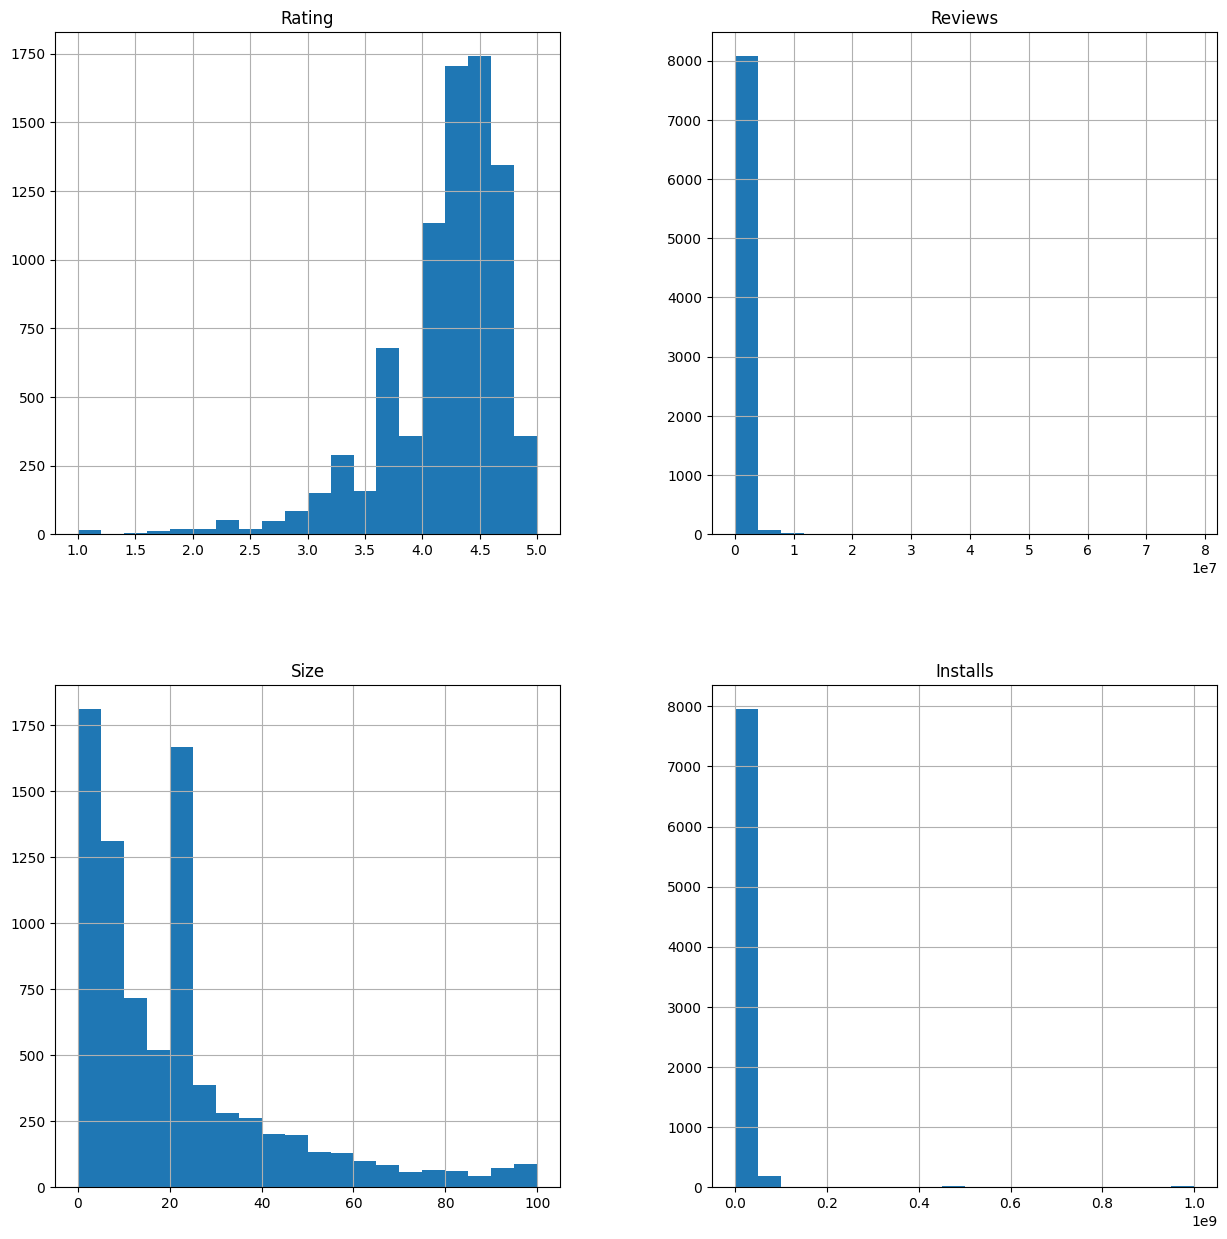

In [17]:
def print_histograms(dataset):
    dataset.hist(column = ['Rating', 'Reviews', 'Size', 'Installs'], bins = 20, figsize=(15, 15))
    plt.show()
print_histograms(dataset)

# Compute correlations matrix

In [18]:
def compute_correlations_matrix(dataset, columns = None):
    plt.figure(figsize = (15, 10))
    
    sns.heatmap(data = dataset[columns].corr(), annot=True, linewidth=0.5)
    plt.show()

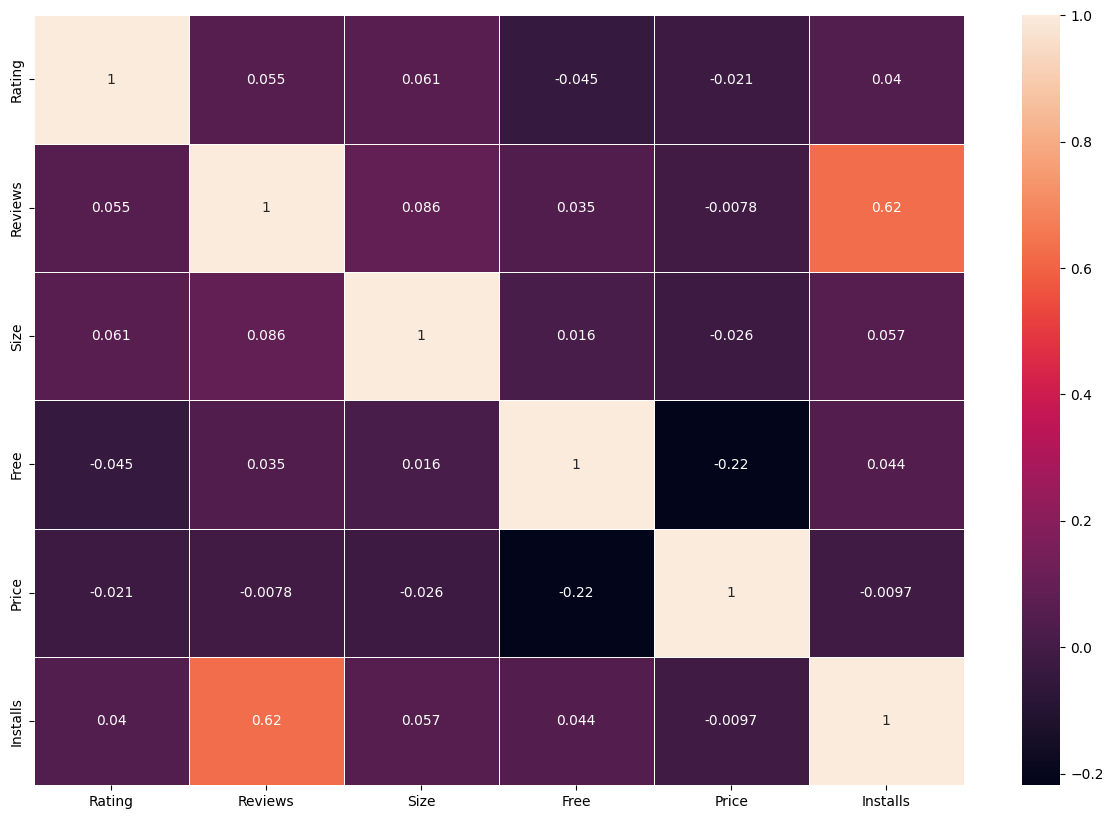

In [19]:
compute_correlations_matrix(dataset, columns = ['Rating', 'Reviews', 'Size', 'Free', 'Price', 'Installs'])

## Plot with bar diagram the most populars paid apps of Family, Games and Tools category

In [20]:
def top_apps_type(dataset):
    figure, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=(17, 7))
    games = dataset['Free'][dataset['Category'] == 'Game']
    tools = dataset['Free'][dataset['Category'] == 'Tools']
    family = dataset['Free'][dataset['Category'] == 'Family']


    free, paied = calculate_free(games)
    ax1.bar('Free', free, width=0.3)
    ax1.bar('Paied', paied, width=0.3)
    ax1.set_title('Games')
    ax1.bar_label(ax1.containers[1], fmt='%.1f')
    ax1.bar_label(ax1.containers[0], fmt='%.1f')
    
    free, paied = calculate_free(family)
    ax2.bar('Free', free, width=0.3)
    ax2.bar('Paied', paied, width=0.3)
    ax2.set_title('Family')
    ax2.bar_label(ax2.containers[1], fmt='%.1f')
    ax2.bar_label(ax2.containers[0], fmt='%.1f')

    free, paied = calculate_free(tools)
    ax3.bar('Free', free, width=0.3)
    ax3.bar('Paied', paied, width=0.3)
    ax3.set_title('Tools')
    ax3.bar_label(ax3.containers[1], fmt='%.1f')
    ax3.bar_label(ax3.containers[0], fmt='%.1f')

    
    plt.show()

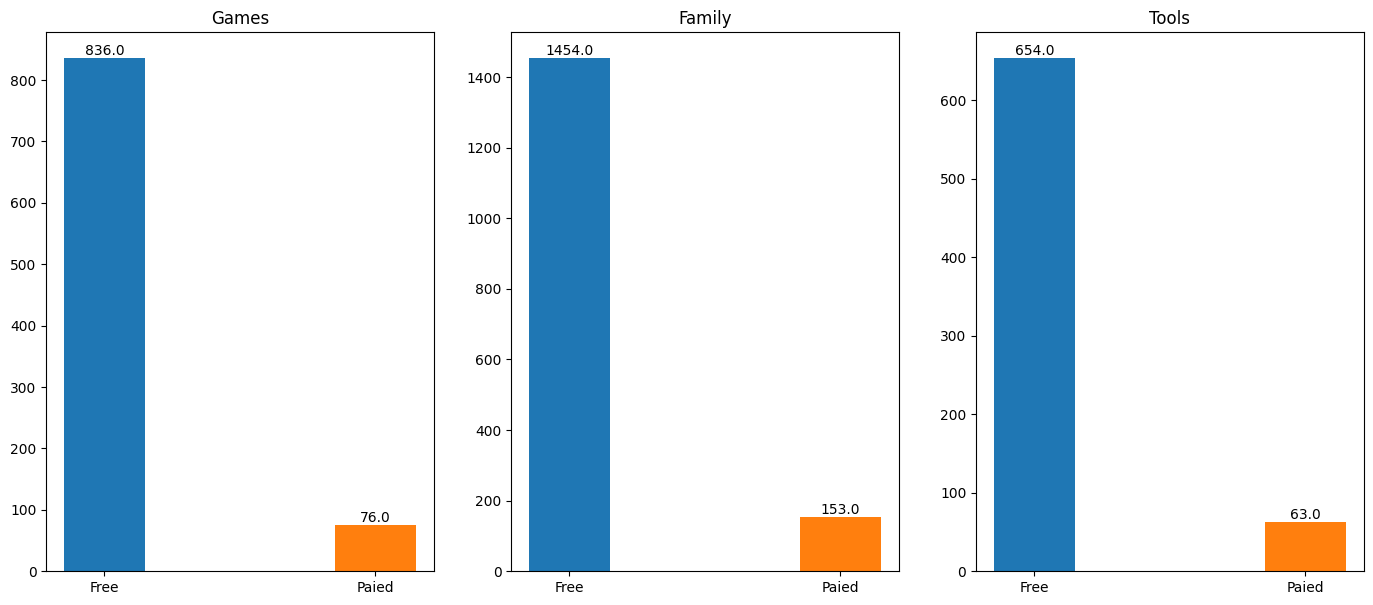

In [21]:
top_apps_type(dataset)

## Most popular genres according to the number of installations from paid family

In [22]:
def paid_apps(dataset):
    family = dataset[(dataset['Category'] == 'Family') & (dataset['Free'] == 0)]

    family = family.sort_values('Installs', ascending = False).head(20)

    plt.figure(figsize = (25, 20))
    plt.title("Top 10 Paid Apps in Family Category")
    sns.barplot(data = pd.DataFrame({'App' : family['App'], 'Number of Installs' : family['Installs']}), y='App', x = 'Number of Installs')
    
    plt.show()

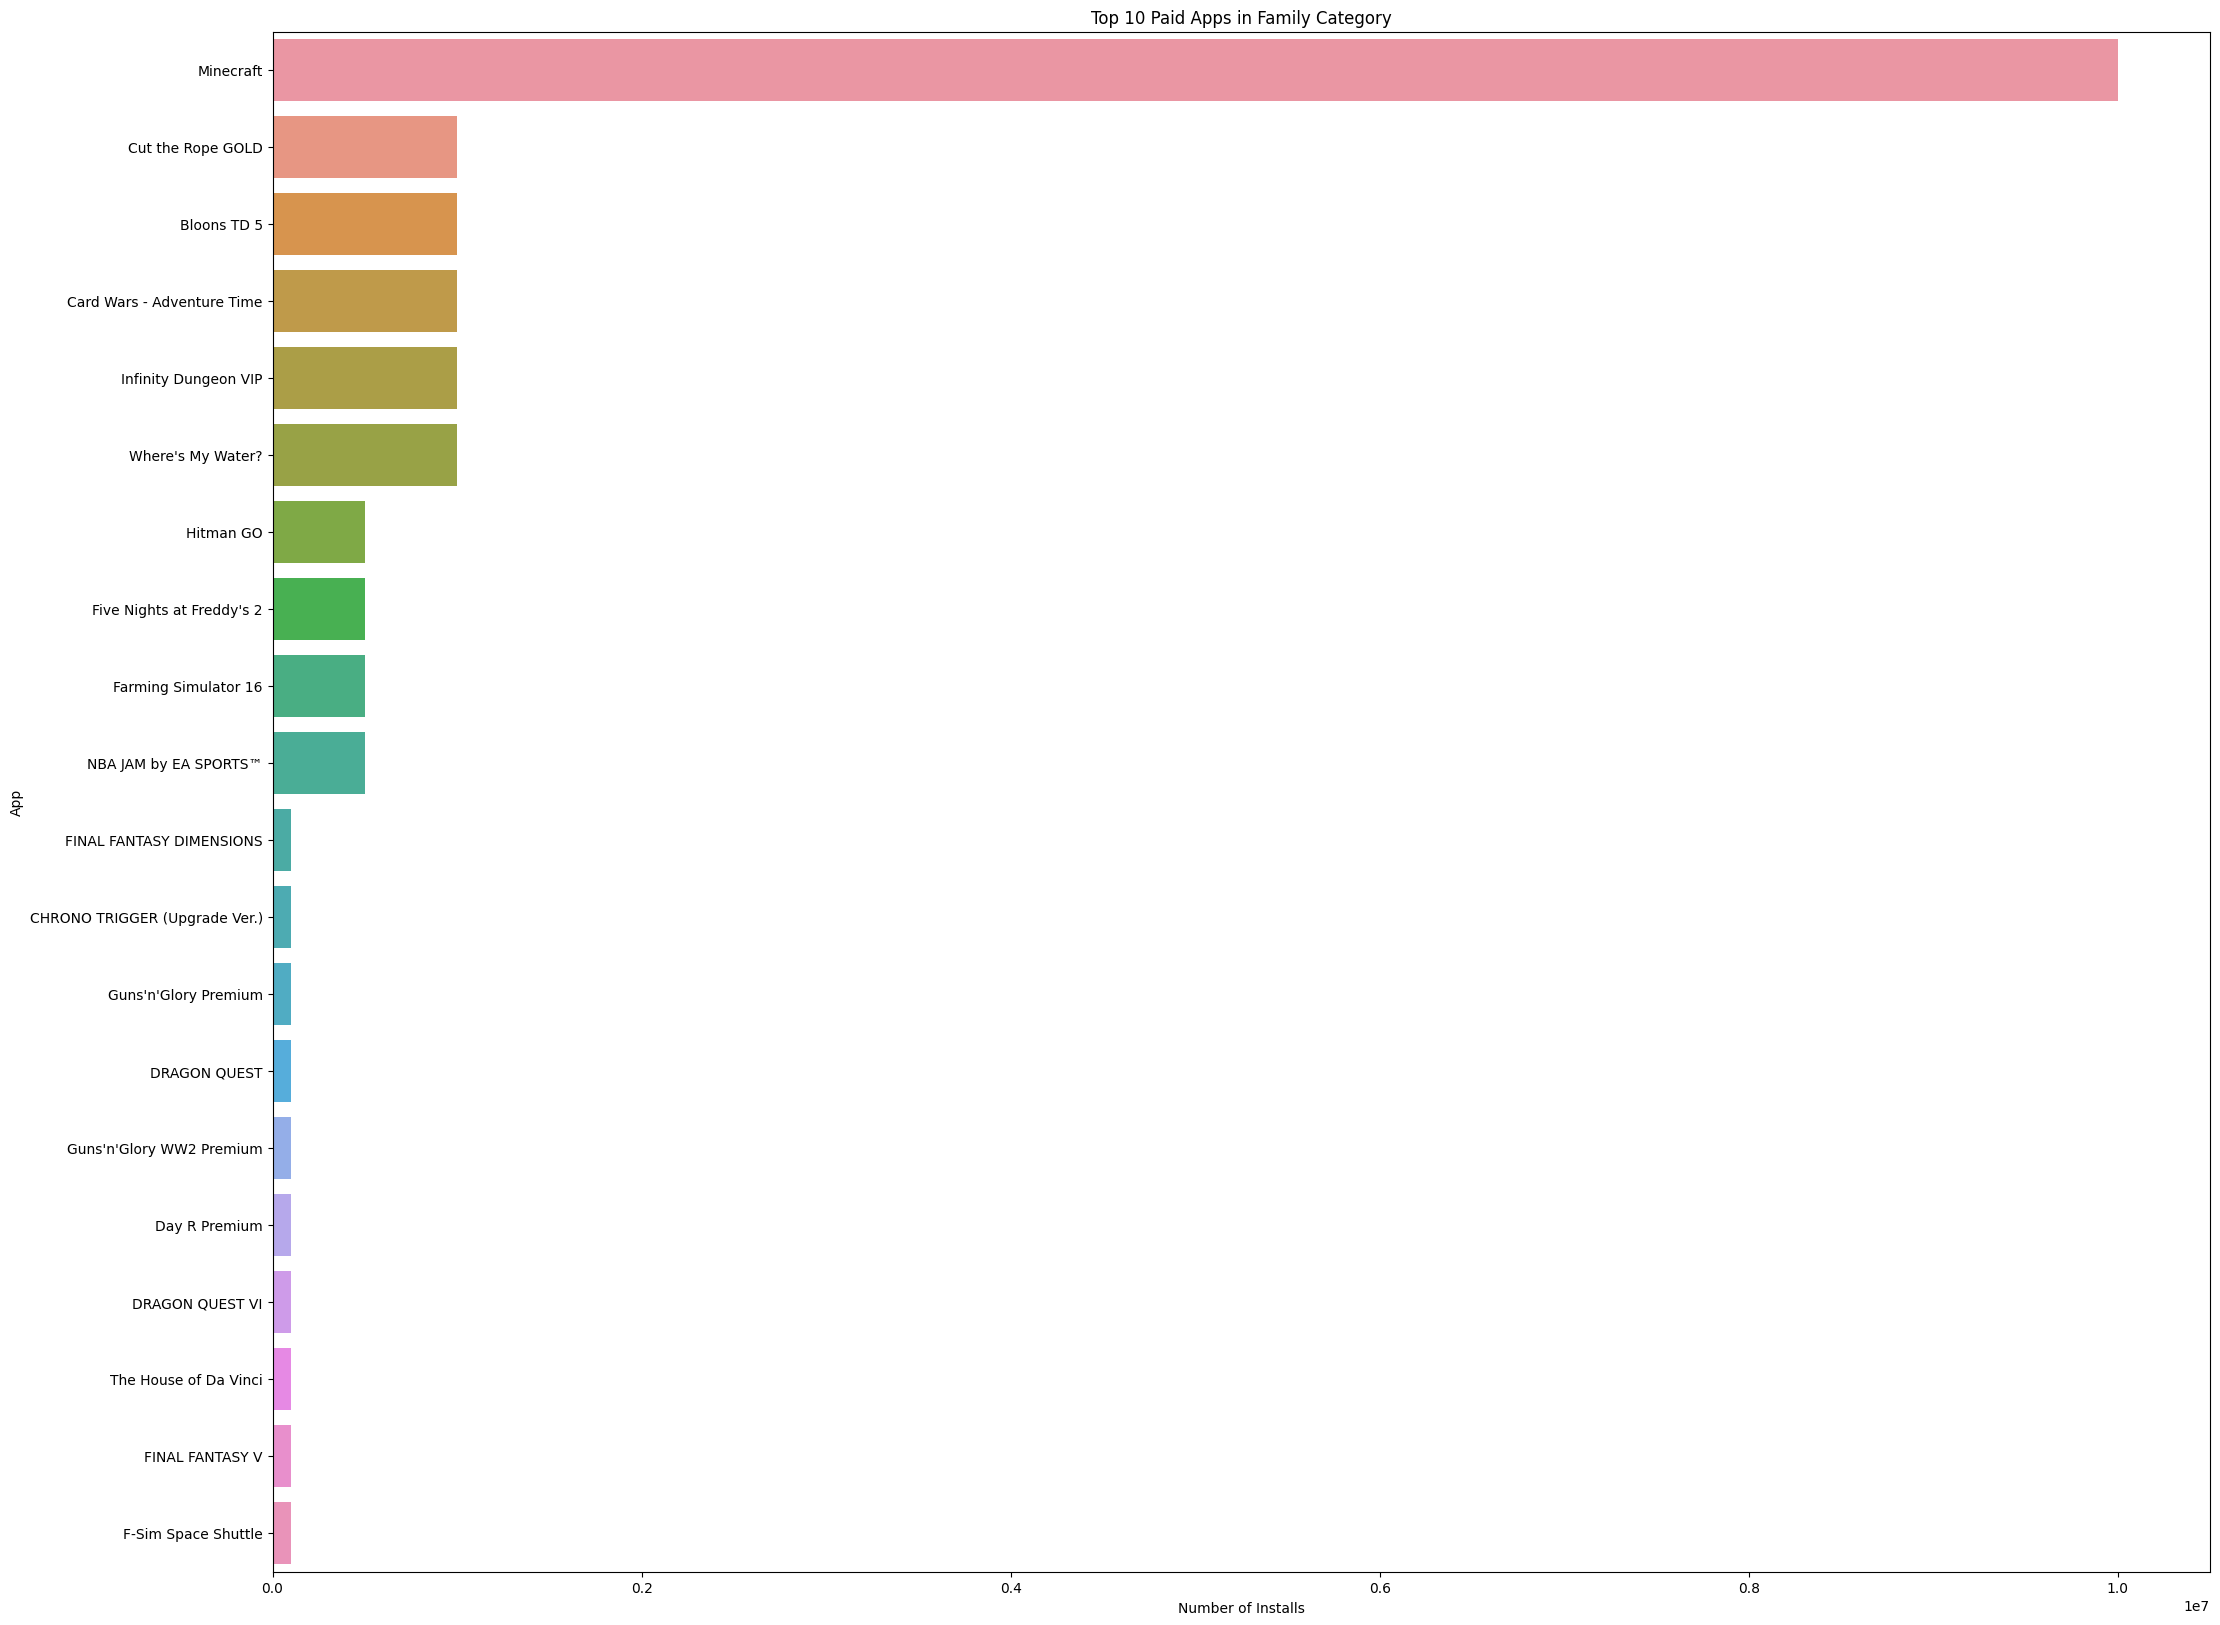

In [23]:
paid_apps(dataset)

# Plot a pie with the number of installation per category

In [24]:
def pie_installs(dataset):
    categories = dataset['Category'].unique()

    count = []
    for categori in categories:
        count.append(dataset[dataset['Category'] == categori]['Installs'].sum())

    count = pd.DataFrame({'Category' : categories, 'Count' : count})    
    count.sort_values('Count', ascending = False, inplace=True)
    count = count.head(15)

    plt.figure(figsize = (10, 10))
    plt.title("Number of installation per category")
    
    color = sns.color_palette()
    plt.pie(count['Count'], labels = count['Category'], autopct='%.0f%%', colors = color)

    plt.show()

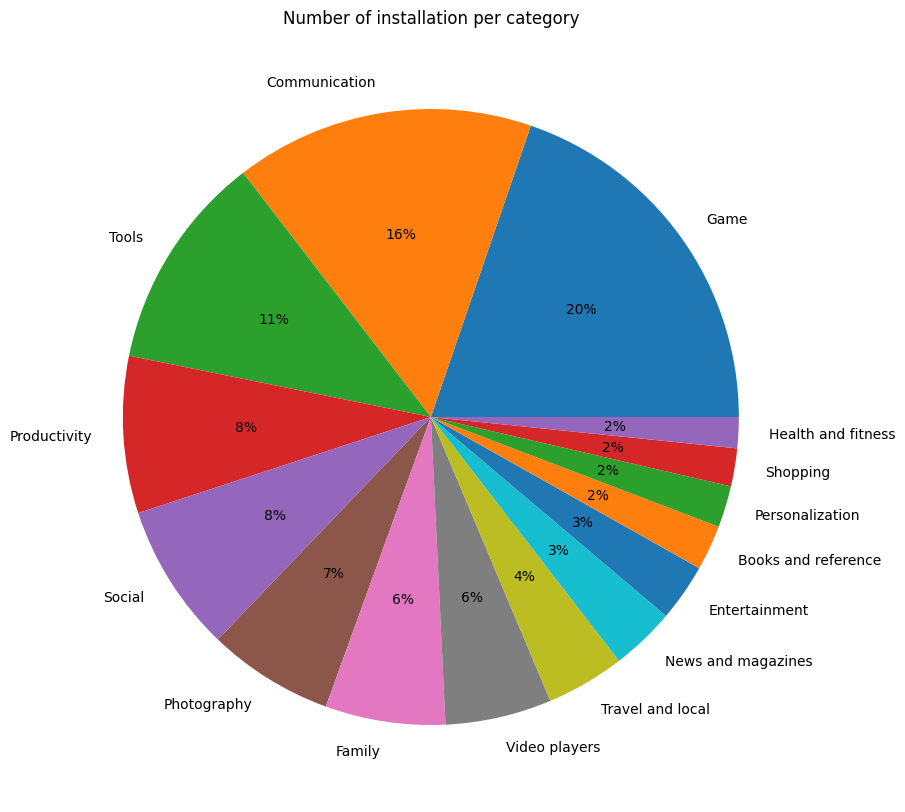

In [25]:
pie_installs(dataset)

# Number of category apps

In [26]:
def pie_category_apps(dataset):
    count = dataset['Category'].value_counts()
    count.sort_values(ascending = False, inplace = True)

    count = dataset['Category'].value_counts()
    plt.figure(figsize = (10, 10))

    colors = sns.color_palette()
    plt.pie(count.values[:10], labels = count.index[:10], autopct='%.0f%%', colors = colors)
    plt.title("Number of category apps")
    plt.legend(count.index[:5])
    plt.show()

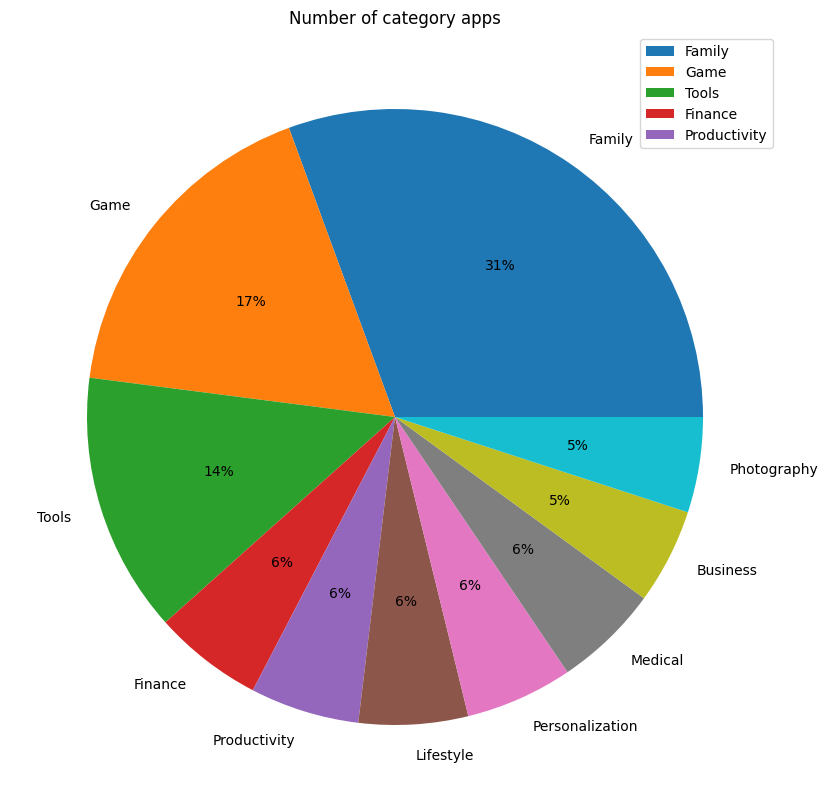

In [27]:
pie_category_apps(dataset)

# Most expensive apps per category

In [129]:
def plot_bar_expensive_apps(dataset):
    paied = dataset[dataset['Free'] == 0]

    categoryes = paied['Category'].unique()
    respons = []
    for category in categoryes:
        respons.append(paied[paied['Category'] == category]['Price'].mean())

    answer = pd.DataFrame({'Category' : categoryes, 'Mean price' : respons})
    answer.dropna(inplace = True)

    answer.sort_values('Mean price', ascending = False, inplace=True)
    
    plt.figure(figsize=(15, 10))
    sns.barplot(answer.head(15), x = 'Mean price', y ='Category')

    plt.show()

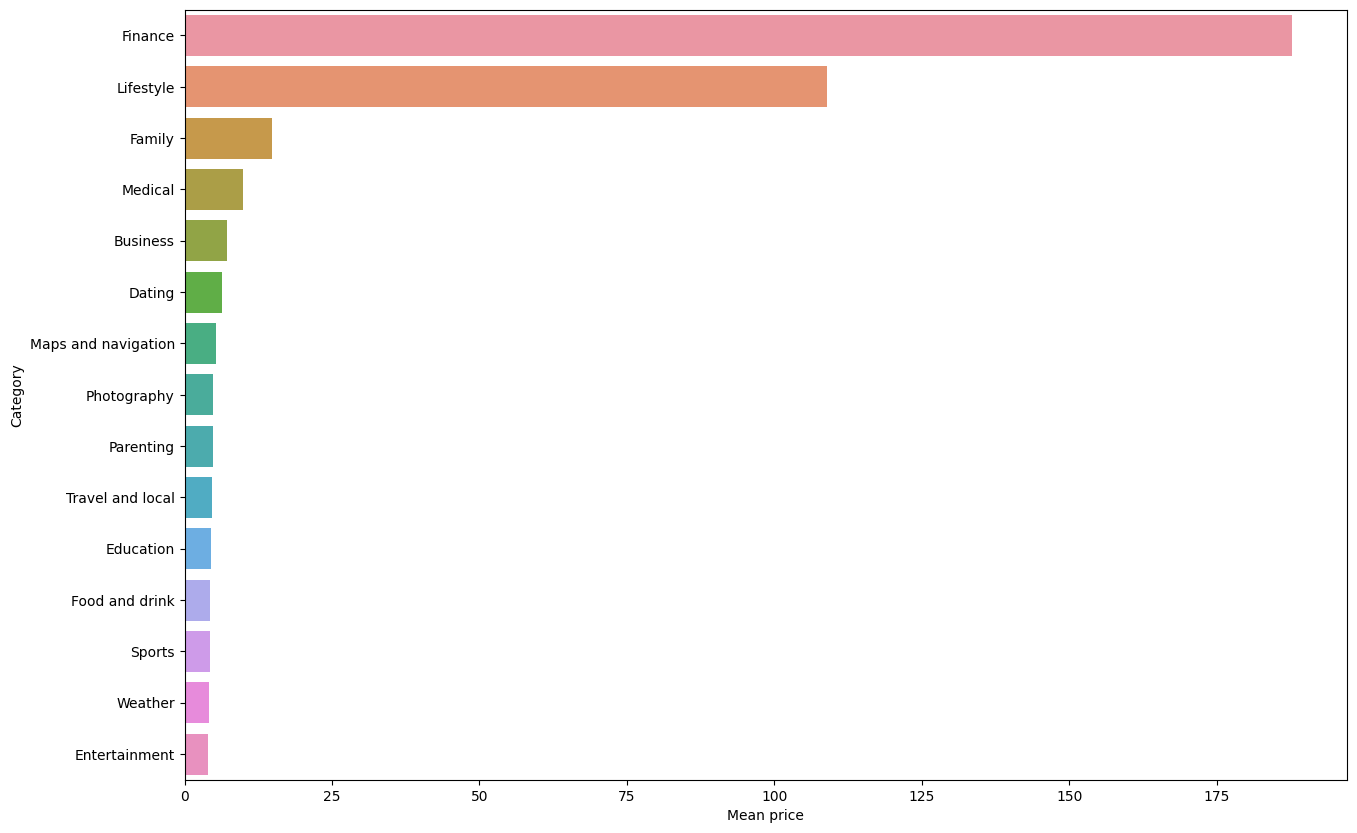

In [130]:
plot_bar_expensive_apps(dataset)

# Top 20  Family apps with the highest user ratings

In [132]:
def family_apps_ratings(dataset):
    social = dataset[(dataset['Category'] == 'Family')].sort_values(['Reviews', 'Installs', 'Rating'], ascending = False).head(20)

    plt.figure(figsize=(30, 20))
    sns.barplot(social, x = 'Reviews' , y = 'App')

    plt.show()

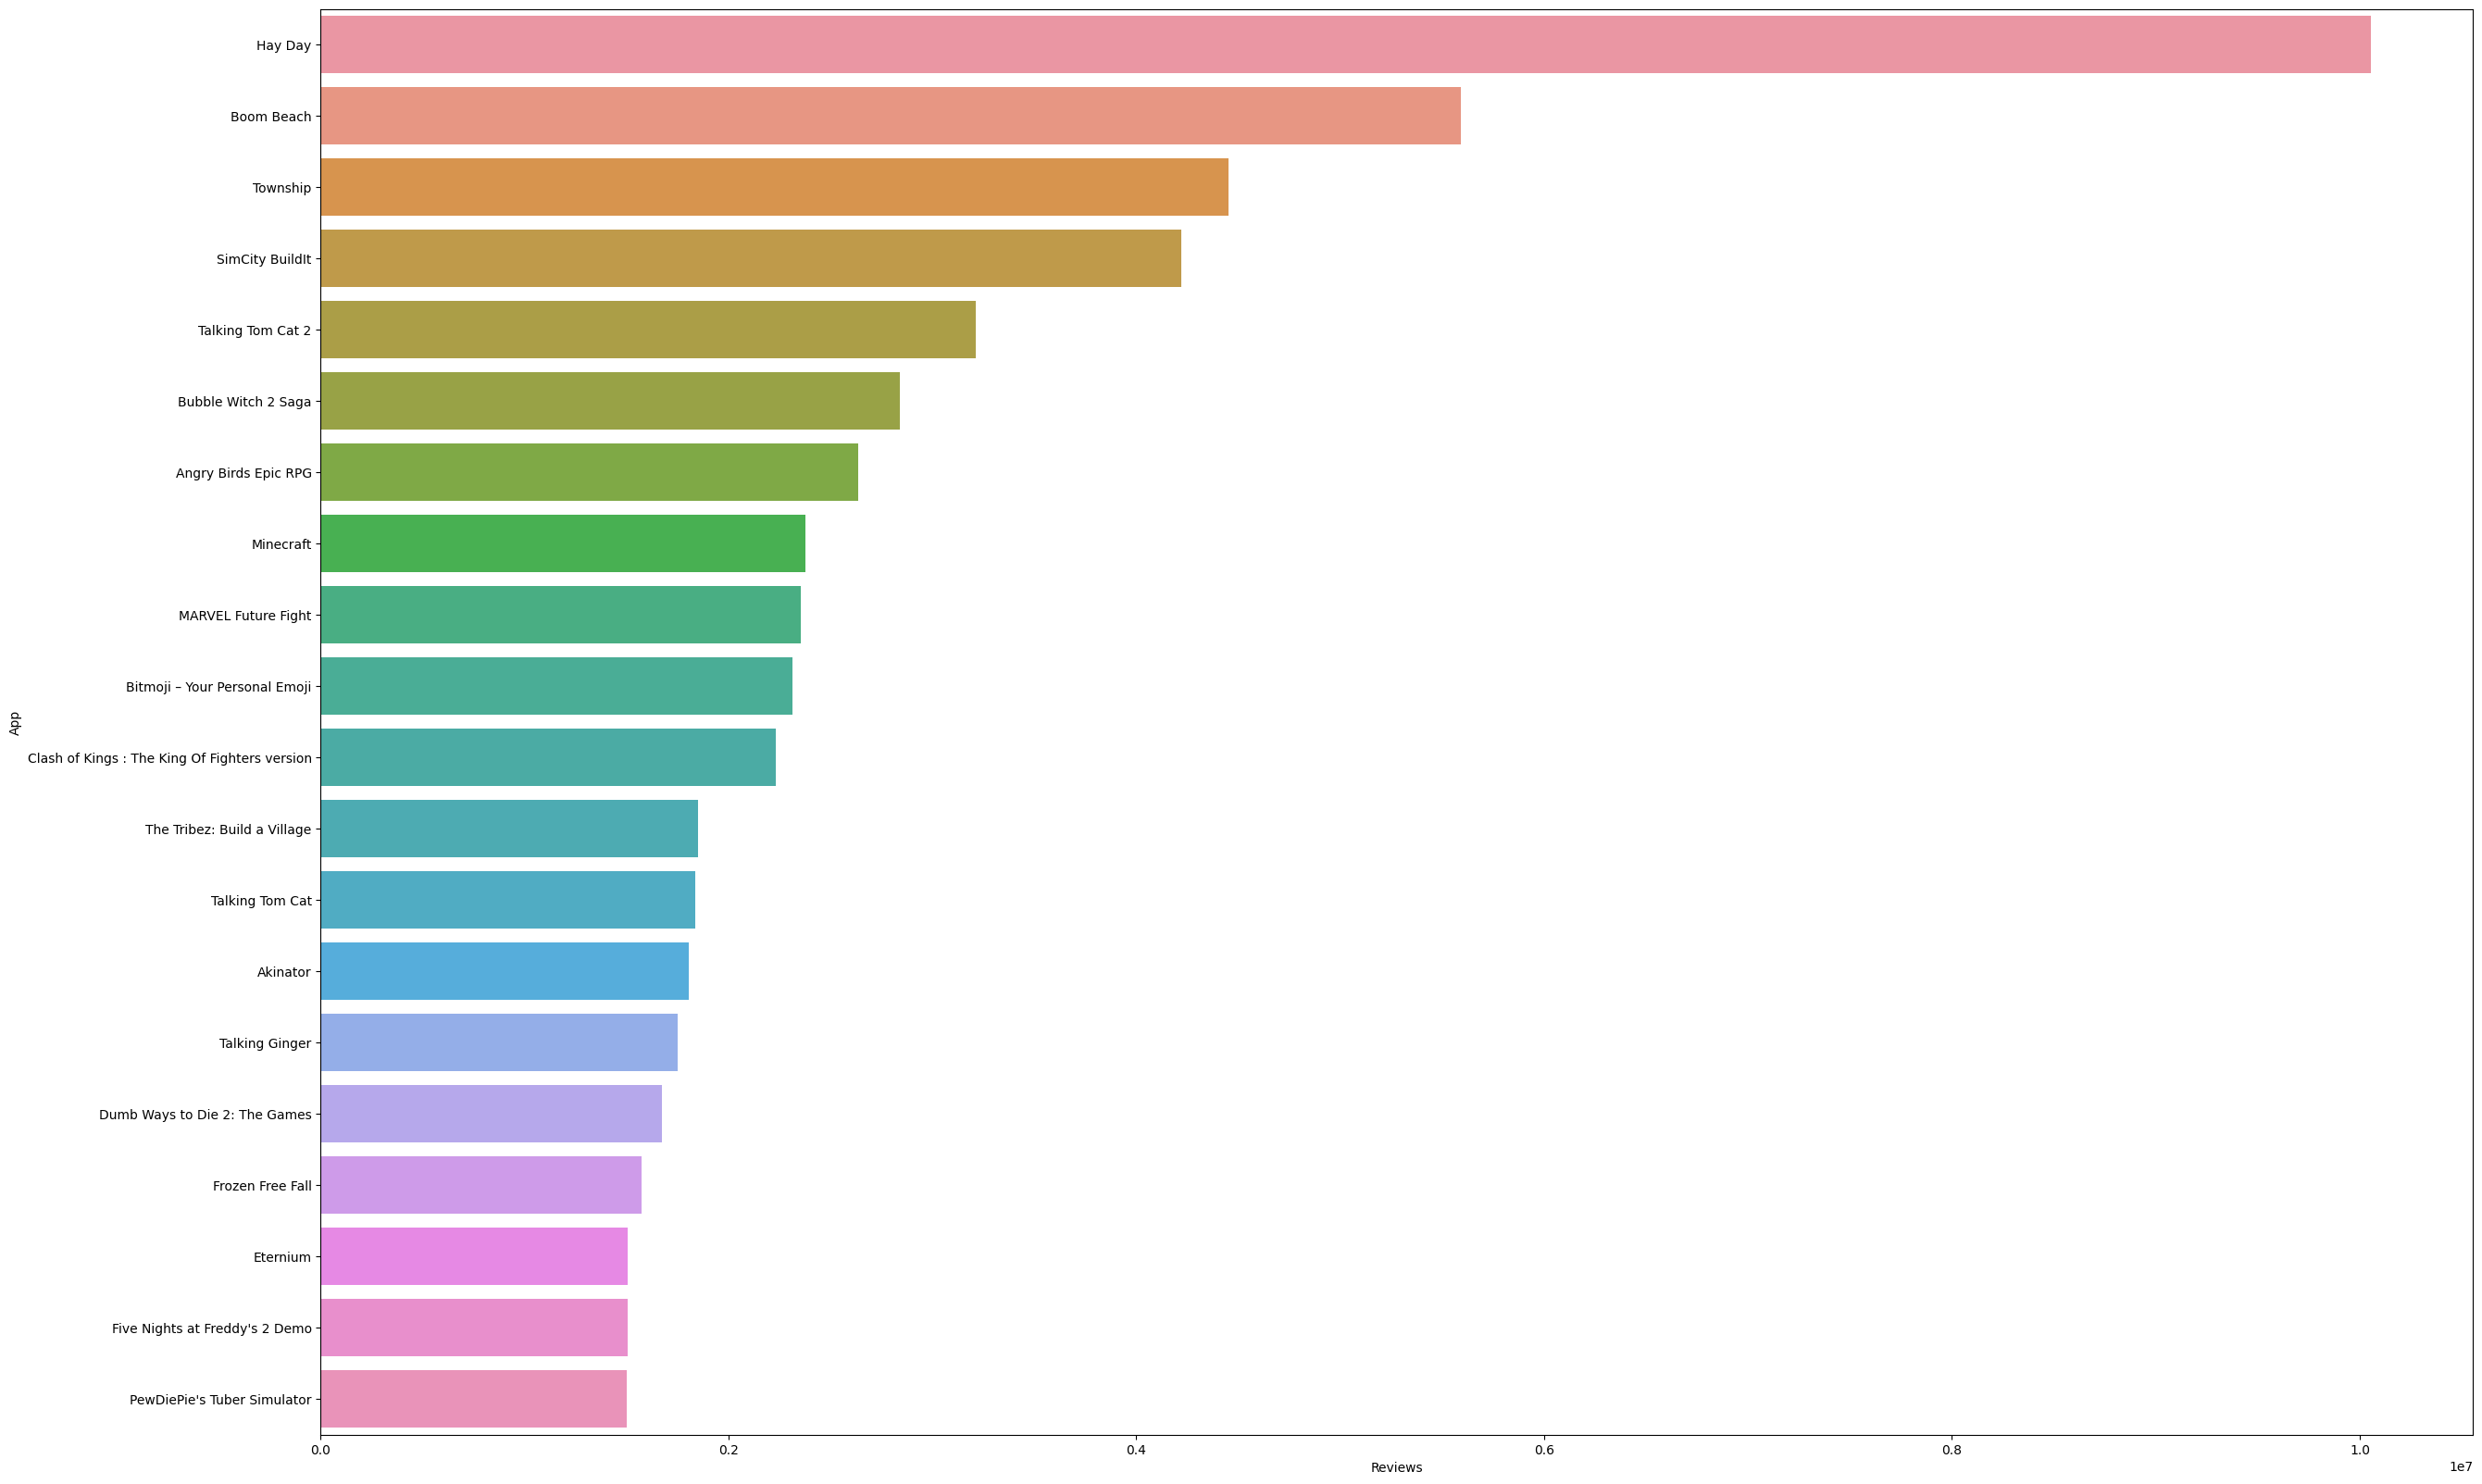

In [133]:
family_apps_ratings(dataset)

In [ ]:
! git add >